# Heuristic Search 

In [1]:
import gym
import minihack
import numpy as np
import matplotlib.pyplot as plt

from map_utils import *
from search import *
from graphics_utils import *

## 1. The Fully Observable Environment

Initially, a simpler version of the problem was tackled. An A* algorithm was implemented that could find the optimal path in a map with trees.


Hello Agent, welcome to NetHack!  You are a chaotic male human Rogue.           
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                          ...                                   
                                  @...#.#...>                                   
                                  #..........                                   
                                  #.#......#.                                   
                                  ......###..                                   
                           

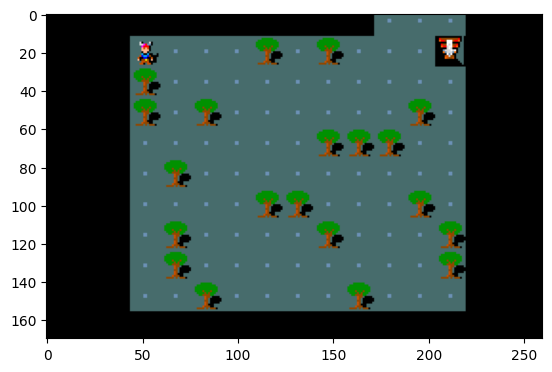

In [42]:
# create the environment
des_custom1= """ MAZE: "mylevel", ' '
FLAGS:hardfloor,premapped
MESSAGE: "Welcome to MiniHack!"
INIT_MAP: solidfill,' '
GEOMETRY:center,center
MAP
...........
...........
...........
...........
...........
...........
...........
...........
...........
ENDMAP
$place = { (10,8),(0,8),(10,0) }
SHUFFLE: $place
REGION:(0,0,11,9),lit,"ordinary"
REPLACE_TERRAIN:(0,0,11,9), '.', 'T', 30%
TERRAIN:randline (0,9),(11,0), 5, '.'
TERRAIN:randline (0,0),(11,9), 5, '.'
BRANCH:(0,0,0,0),(1,1,1,1)
STAIR:$place[2],down
"""

env = gym.make("MiniHack-Navigation-Custom-v0", observation_keys=["chars", "pixel", "colors"], des_file=des_custom1)
# reset it to initial state
state = env.reset()
# render the environment
env.render()

plt.imshow(state["pixel"][100:270, 500:760])

In [ ]:
game_map = state["chars"]
color_map = state["colors"]
game = state["pixel"]

start = get_player_location(game_map)
target = get_target_location(game_map)
print("Agent position:", start)
print("Target position:", target)

In [ ]:
%%time
path = a_star(game_map, color_map, start, target, euclidean_distance)
actions = actions_from_path(start, path[1:])
x = render_actions(actions, env, game)



The algorithm also works on more intricate map configurations, that are not constrained to a square shape.

In [ ]:
des_custom2= """ MAZE: "mylevel", ' '
FLAGS:hardfloor,premapped
MESSAGE: "Welcome to MiniHack!"
INIT_MAP: solidfill,' '
GEOMETRY:center,center
MAP
|||||||||||||||||||
|.................|
|..|||||....|..|..|
|..|   |..|||||||.|
|..||| |.......|..|
|....| |||||||.||.|
|....|       |.|..|
|....|       |....|
||||||  ||||||....|
        |......|..|
        |......||.|
        |.........|
        |||||||||||
ENDMAP
REGION:(0,0,11,9),lit,"ordinary"
REPLACE_TERRAIN:(0,0,11,9), '.', 'T', 25%
TERRAIN:randline (0,9),(11,0), 5, '.'
STAIR:(10, 10),down
BRANCH: (3,6,3,6),(4,7,4,7)
"""

env = gym.make("MiniHack-Navigation-Custom-v0", observation_keys=["chars", "pixel", "colors"], des_file=des_custom2)
# reset it to initial state
state = env.reset()
# render the environment
env.render()
plt.imshow(state["pixel"])

In [ ]:
game_map = state["chars"]
color_map = state["colors"]
game = state["pixel"]

start = get_player_location(game_map)
target = get_target_location(game_map)
print("Agent position:", start)
print("Target position:", target)

In [ ]:
%%time
path = a_star(game_map, color_map, start, target, euclidean_distance)
actions = actions_from_path(start, path[1:])
render_actions(actions, env, game)

The problem was made more complex with the introduction of clouds and a "grid bug," a relatively weak monster in Nethack. This creature, matching the player's speed, is unable to ever catch up with the agent, adding a strategic element to the scenario. 

To effectively face this issue, a dynamic A* algorithm was implemented. This  solution recalculates the path based on whether the monster is visible or not. In scenarios where the monster is visible, the agent incurs no penalties traversing through clouded areas. Instead, in instances where the monster remains hidden, traversing through clouded regions carries a risk, as these areas could be secret hiding places for the lurking monster.


In [ ]:
des_custom3= """ MAZE: "mylevel", ' '
FLAGS:hardfloor,premapped
MESSAGE: "Welcome to MiniHack!"
INIT_MAP: solidfill,' '
GEOMETRY:center,center
MAP
...........
...........
...........
...........
...........
...........
...........
...........
...........
ENDMAP
$place = { (10,8),(0,8),(10,0) }
SHUFFLE: $place
REGION:(0,0,11,9),lit,"ordinary"
REPLACE_TERRAIN:(0,0,11,9), '.', 'C', 33%
REPLACE_TERRAIN:(0,0,11,9), '.', 'T', 25%
TERRAIN:randline (0,9),(11,0), 5, '.'
TERRAIN:randline (0,0),(11,9), 5, '.'
BRANCH:(0,0,0,0),(1,1,1,1)
STAIR:$place[2],down
MONSTER: "grid bug", $place[0], hostile
"""

env = gym.make("MiniHack-Navigation-Custom-v0", observation_keys=["chars", "pixel", "colors"], des_file=des_custom3)
# reset it to initial state
state = env.reset()
# render the environment
env.render()

plt.imshow(state["pixel"][75:300, 450:800])

In [ ]:
game_map = state["chars"]
color_map = state["colors"]
game = state["pixel"]

start = get_player_location(game_map)
target = get_target_location(game_map)
print("Agent position:", start)
print("Target position:", target)


In [ ]:

actions = dynamic_pathfinding(game_map, color_map, start, target, chebyshev_distance)
render_actions(actions, env, game)
   

The final stage of the fully observable problem involved addressing the comprehensive challenge at hand. A diverse array of monsters was integrated into the scenario. 



Hello Agent, welcome to NetHack!  You are a chaotic male human Rogue.           
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                          ...                                   
                                  @#..####..>                                   
                                  #.#.#....#.                                   
                                  ...##......                                   
                                  #.....##.##                                   
                           

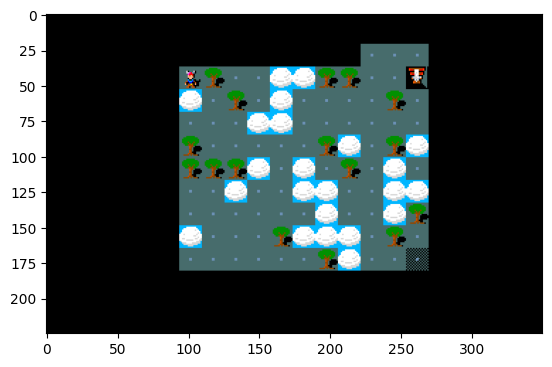

In [39]:
env = gym.make("MiniHack-HideNSeek-Mapped-v0", observation_keys=["chars", "pixel", "colors"])
# reset it to initial state
state = env.reset()
# render the environment
env.render()

plt.imshow(state["pixel"][75:300, 450:800])

In [40]:
game_map = state["chars"]
color_map = state["colors"]
game = state["pixel"]

start = get_player_location(game_map)
target = get_target_location(game_map)
print("Agent position:", start)
print("Target position:", target)

Agent position: (7, 34)
Target position: (7, 44)


In [2]:
env = gym.make("MiniHack-Skill-Custom-v0", des_file="dat/fully_observable_c.des", observation_keys=["chars", "pixel", "colors"])
win, loss, monsters_win, monsters_loss = evaluate_performance(env, dynamic_path_finding, evaluation_steps=10)

print(f"wins: {win}")
print(f"beaten monsters: {monsters_win}")
print(f"losses: {loss}")
print(f"monster that got us beaten: {monsters_loss}")

wins: 7
beaten monsters: ['N', 'H', 'H', None, 'H', 'N', 'H']
losses: 3
monster that got us beaten: ['N', 'N', 'N']


('W', 'N')

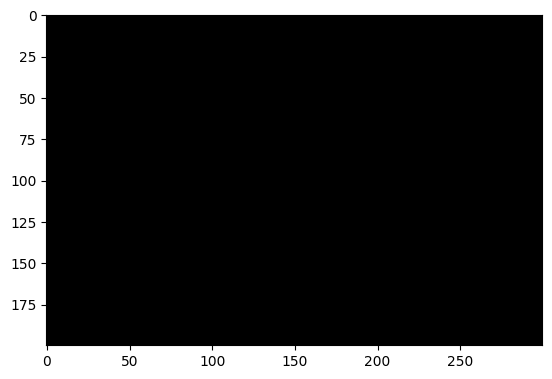

In [6]:
env = gym.make("MiniHack-Skill-Custom-v0", des_file="dat/fully_observable_c.des", observation_keys=["chars", "pixel", "colors"])
state = env.reset()
game_map = state["chars"]
color_map = state["colors"]
pixel_map = state["pixel"]
start = get_player_location(game_map)
target = get_target_location(game_map)
dynamic_path_finding(game_map, color_map, start, target, env, chebyshev_distance, graphics=True, pixel_map=pixel_map)